# Import libraries 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.neighbors import BallTree


# Load and Clean Data

In [2]:
csv_file='/Users/ze/Documents/Coding/Projects/2024/alturos/data/raw/v5_20230407_091351_95m.csv'

In [3]:
# Load data -- preprocessed would be ideal 
df = pd.read_csv(csv_file)

# Identify Lift Rides

In [4]:
# input from somewhere else? 

In [5]:
# Convert 'Timestamp' to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

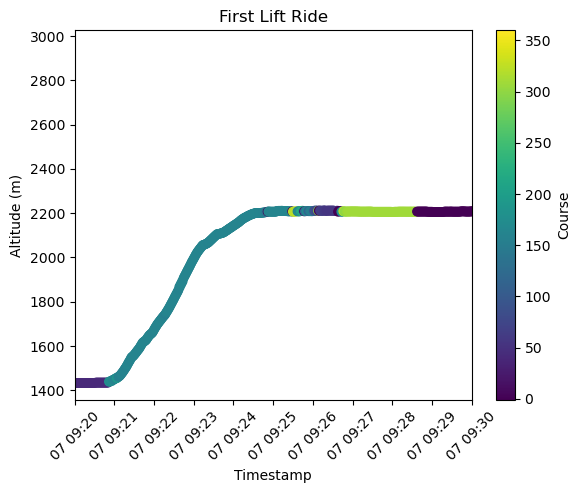

In [6]:
from datetime import datetime

# Define limits for x-axis
left_margin = datetime(year=2023, month=4, day=7, hour=9, minute=20)
right_margin = datetime(year=2023, month=4, day=7, hour=9, minute=30)

# Plotting
fig, ax = plt.subplots()

# Create a scatter plot to have a colorbar
sc = ax.scatter(df['Timestamp'], df['Alt(m)'], c=df['Course'], cmap='viridis')

# Create colorbar with label 'Course'
colorbar = plt.colorbar(sc, ax=ax)
colorbar.set_label('Course')

# Set plot title and labels
ax.set_title('First Lift Ride')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Altitude (m)')

# x-axis  
plt.xticks(rotation=45)
plt.xlim(left_margin, right_margin)

plt.show()

In [7]:
import plotly.express as px

# Define limits for x-axis
left_margin = datetime(year=2023, month=4, day=7, hour=9, minute=20)
right_margin = datetime(year=2023, month=4, day=7, hour=9, minute=26)

# Filter data based on x-axis limits
df_filtered = df[(df['Timestamp'] >= start_time) & (df['Timestamp'] <= end_time)]

# Create a scatter plot using Plotly Express
fig = px.scatter(df_filtered, x='Timestamp', y='Alt(m)',
                 color='Course', color_continuous_scale='Viridis',
                 title='First Lift Ride')

# Set the range for the x-axis
fig.update_xaxes(range=[left_margin, right_margin], tickangle=45)

# Set axis labels
fig.update_xaxes(title_text='Timestamp')
fig.update_yaxes(title_text='Altitude (m)')

fig.show()


NameError: name 'start_time' is not defined

In [ ]:
# timestamp from lift start 
start_time = datetime(year=2023, month=4, day=7, hour=9, minute=20)

In [ ]:
# Define a time delta - the window around 'start_time' to average location data
time_delta = pd.Timedelta(minutes=1)  # for example, +/- 1 minute

# Filter the data to this time window
time_window_df = df[(df['Timestamp'] >= start_time - time_delta) & (df['Timestamp'] <= start_time + time_delta)]

# Calculate the average location
average_location = time_window_df[['Lat', 'Long']].mean()
average_location

# Load lifts database 


Data could be scraped from [Skiresort Info](https://www.skiresort.info/ski-resort/gemsstock-andermatt/ski-lifts/l87981/)

In [12]:
# Load lift geolocations into a DataFrame
lifts_df = pd.DataFrame({
    'ski_region':['Andermatt-Gurschenalp'],
    'lift_name': ['Gurschen-Bahn'],
    'lift_name': ['Andermatt-Gurschen'],
    'base_station': ['1444 m'],
    'top_station':['2212 m'],
    'latitude': [46.632443],
    'longitude': [8.591929],
    'transit_time': ['approx. approx. 3:20 minutes'],
    'speed': ['10 m/s'],
    'construction_date': [1991]
})

In [13]:
lifts_df.head()

,ski_region,lift_name,base_station,top_station,latitude,longitude,transit_time,speed,construction_date
0,Andermatt-Gurschenalp,Andermatt-Gurschen,1444 m,2212 m,46.632443,8.591929,approx. approx. 3:20 minutes,10 m/s,1991


# Match to Nearest Lift


In [14]:
# Convert lat/long to radians for the BallTree
user_latitude=46.632443
user_longitude=8.591929

lifts_coords = np.radians(lifts_df[['latitude', 'longitude']].values)

# Convert user latitude and longiasciitude to radians and wrap them in a 2D array
user_coords = np.radians([[user_latitude, user_longitude]])


In [20]:
# Use BallTree to find the nearest lift
tree = BallTree(lifts_coords, metric='haversine')
indices = tree.query(user_coords, return_distance=False)

In [21]:
# Get the row for the nearest lift
nearest_lift_row = lifts_df.iloc[indices.flatten()[0]]

# Print each column and value with a line break
for column in nearest_lift_row.index:
    print(f"{column}: {nearest_lift_row[column]}")

ski_region: Andermatt-Gurschenalp
lift_name: Andermatt-Gurschen
base_station: 1444 m
top_station: 2212 m
latitude: 46.632443
longitude: 8.591929
transit_time: approx. approx. 3:20 minutes
speed: 10 m/s
construction_date: 1991


In [ ]:
def identify_current_lift(location, lifts_db, k=1):
    # Convert user_location to radians
    location_rad = np.radians([location])
    
    # Convert lift base locations to radians
    lift_base_locations_rad = np.radians([[lift['base_latitude'], lift['base_longitude']] for _, lift in lifts_db.iterrows()])
    # Convert lift top locations to radians
    lift_top_locations_rad = np.radians([[lift['top_latitude'], lift['top_longitude']] for _, lift in lifts_db.iterrows()])

    # Use BallTree to find the k nearest lifts for base locations
    base_tree = BallTree(lift_base_locations_rad, metric='haversine')
    base_distances, base_indices = base_tree.query(location_rad, k=k)

    # Use BallTree to find the k nearest lifts for top locations
    top_tree = BallTree(lift_top_locations_rad, metric='haversine')
    top_distances, top_indices = top_tree.query(location_rad, k=k)
    
    # Combine distances from both base and top locations
    all_distances = np.concatenate((base_distances, top_distances), axis=1)
    all_indices = np.concatenate((base_indices, top_indices), axis=1)
    
    # Find the closest lift among base and top locations
    min_distance_index = np.argmin(all_distances)
    nearest_lift_index = all_indices.flatten()[min_distance_index]
    
    # Get the information for the nearest lift
    nearest_lift = lifts_db.iloc[nearest_lift_index]
    nearest_lift_distance = all_distances.flatten()[min_distance_index] * 6371000  # Convert radians to meters
    
    # Return the nearest lift and its distance
    return nearest_lift, nearest_lift_distance

# Example usage:
location = (46.632472824927596, 8.592125943352368)
nearest_lift, distance_to_lift = identify_current_lift(location, lifts_db, k=1)
print(nearest_lift)
print(distance_to_lift)
